In [1]:
%matplotlib inline
from qutip import *
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from numpy import sqrt, pi,sin,cos, linspace

# Correlations

Our goal is finding autocorrelation function $g^{(2)}(\tau)$ under incoherent excitation of the atom.


$\frac{d\hat{\rho}}{dt}= -i[\hat{H}_{0}+\hat{V}_{p}(t), \hat{\rho}] \\
  \;\;\;\;\;\;\; +\gamma_{c}L[\hat{a}]\hat{\rho}+\gamma_{a}L[\hat{\sigma}_{-}]\hat{\rho}+\
  \color{red}{\gamma_{inc}L[\hat{\sigma}_{+}]\hat{\rho}} \\
  \;\;\;\;\;\;\; +n_{th}\gamma_{m}L[\hat{b}^\dagger]
  +(n_{th}+1)\gamma_{m} L[\hat{b}]\hat{\rho}$
  
  which $\gamma_{inc}$ is incoherent driving rate

The optical second-order autocorrelation function in the steady-state regime:

$\large{g^{(2)}(\tau)=\Large{\frac{\langle \hat{a}^ \dagger (t) \hat{a}^ \dagger (t+ \tau ) \
  \hat{a}(t+\tau) \hat{a}(t) \rangle  }{\langle \hat{a}^ \dagger \hat{a}\rangle ^{2}}}}$

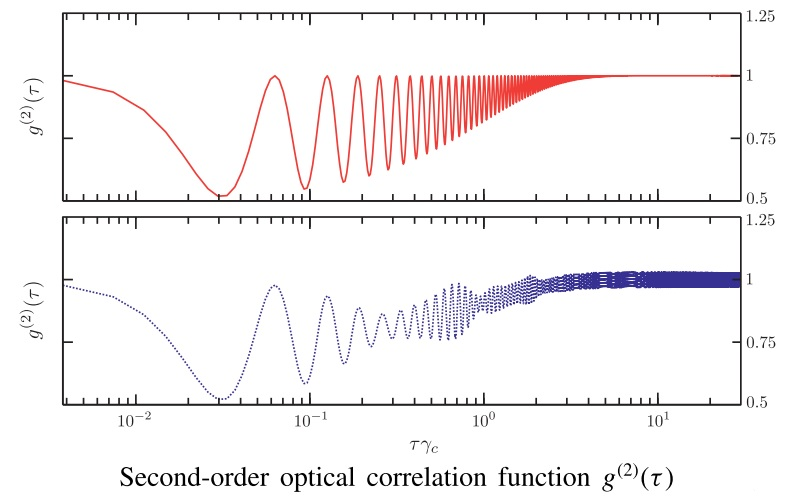

In [5]:
Image(filename='C:/Users/Ahmad/Desktop/2020/Python/g20_Autcr_ SS_03.07.2020/fig.5.jpg'\
      ,width=550, height=450)

#### Figure 5 of the paper. 

In [6]:
# parameter values
n_th=  3.45               # thermal mean phonon occupancy
wm = 1.0                   #  mechanical frequency
wc = 100 * wm                  # cavity frequency.... 
wa = wc                      # resonance case
gamma_a = wa * 1e-4
gamma_c = gamma_a            # atom loss
gamma_m = wm * 1e-4            # mechanical loss

gamma_inc = gamma_c * 1e-3  # incoerent driving rate

g_ac = wm/2.0               # atom-cavity coupling strength
g_cm = 0.1 * wm               # cavity-resonator coupling
F_p = 0.0
####   g_pm= g_cm - 2 * g_am

#########g_pm/g_cm = 0

#g_am = g_cm/2.0    # 
#########  OR  g_pm/g_cm = 1
#g_am = 0.0

######## g_pm/g_cm = -1    used for Fourier transform
g_am = g_cm

# Two cases: g_pm/g_cm = 0 and 1
gamma_inc/gamma_c

0.001

$\tilde{g}_{pm}$ is define as effective polariton-mechanics coupling

$\tilde{g}_{pm}= g_{cm} - 2g_{am}$ \
we plot $g^{(2)}(\tau)$ for two cases:\
$\large \frac{\tilde{g}_{pm}}{g_{cm}}= 0$
and $\large \frac{\tilde{g}_{pm}}{g_{cm}}= 1$


In [3]:
Pars = {"$ \omega_c$": [wc],"$ \omega_a$": [wa],"$ \omega_m$": [wm],\
        "$ g_{ac} /\omega_m$": [g_ac/wm],"$g_{cm}/\omega_m$" : [g_cm/wm],"$\gamma_c/\omega_m$" : [gamma_a/wm],\
        "$ \gamma_{inc} /\gamma_c$":[gamma_inc/gamma_c ],
        "$Q_m$" : [wm/gamma_m],"$Q_c$":[wc/gamma_c],"$Q_a$" : [wa/gamma_a],\
        "$F_p$" : [F_p]\
        ,"$n_{th}$" : [n_th],"$ {\tilde{g}_{pm}}/{g_{cm}}$": "0 and 1"}
dataa = pd.DataFrame(Pars)
dataa


,$ \omega_c$,$ \omega_a$,$ \omega_m$,$ g_{ac} /\omega_m$,$g_{cm}/\omega_m$,$\gamma_c/\omega_m$,$ \gamma_{inc} /\gamma_c$,$Q_m$,$Q_c$,$Q_a$,$F_p$,$n_{th}$,$ {\tilde{g}_{pm}}/{g_{cm}}$
0,100.0,100.0,1.0,0.5,0.1,0.01,0.001,10000.0,10000.0,10000.0,0.0,3.45,0 and 1


### All the values that are used for this simulation are based on above table

In [7]:
#----------------parameters
Nc = 10;      #### photons ##
Nm = 10;     ## phonon dimension  

a = tensor(destroy(Nc),qeye(Nm),qeye(2))     # cavity anihilation operator
b = tensor(qeye(Nc), destroy(Nm),qeye(2))    # phonon anihilation operator
#N_pol= tensor(a.dag()*a , qeye(2)) + tensor(qeye(Nc) , sigmap()*sigmam())    # atom-cavity or polariton oprator

sz = tensor(qeye(Nc), qeye(Nm), sigmaz())
sigma_m = tensor(qeye(Nc), qeye(Nm), sigmam())
sigma_p = tensor(qeye(Nc), qeye(Nm), sigmap())
####################################################
#######################################
# ..........Collapse operators
collapse = []

rate = gamma_c
if rate > 0.0: 
    collapse.append(a * sqrt(rate))
rate = gamma_a
if rate > 0.0 : 
    collapse.append(sigma_m * sqrt(rate))
rate = n_th * gamma_m
if rate > 0.0: 
    collapse.append(b.dag() * sqrt(rate))
rate = (n_th+1) * gamma_m
if rate > 0.0 : 
    collapse.append(b * sqrt(rate))
    
rate = gamma_inc
if rate> 0.0:
    collapse.append(sqrt (gamma_inc) * sigma_p)

"""


collapse.append(sqrt (gamma_c) * a)
collapse.append(sqrt (gamma_a) * sigma_m)
collapse.append(sqrt (gamma_inc) * sigma_p)
collapse.append(sqrt(gamma_m*n_th)*b.dag())
collapse.append(sqrt(gamma_m*(n_th+1))*b)
"""
# ..........Expectation valuses

expct_ops=[]
expct_ops.append(b.dag()*b)
#expct1_ops.append(a.dag()*a)

# opt=Options(nsteps=10000) #where nsteps is some integer greater than 1000     
######################################
#----------------Ideal Dynamics

H1 = wc * a.dag() * a  + wa * sz/2 + wm * b.dag() * b + 1j *  g_ac * (sigma_p * a - sigma_m * a.dag()) \
   - g_cm * a.dag()* a * (b.dag() + b) - g_am * sz * (b.dag() + b)


0.01

In [96]:
# for steady state
taus = np.linspace(0, 1000.0, 4000)

rho0 = steadystate(H0, collapse)
opt=Options(rhs_reuse=True, nsteps=5000)
    # first calculate the occupation number as a function of time
n0 = mesolve(H0, rho0, taus, collapse, [a.dag() * a], options=opt).expect[0]

In [97]:
opt=Options(rhs_reuse=True,nsteps=5000)
G20 = correlation_3op_1t(H0, rho0, taus, collapse, a.dag(), a.dag()*a, a, options=opt)
g20 = G20 / (n0[0] * n0)
#correlation_ss

In [9]:
# for steady state
taus = np.linspace(0, 2500.0, 10000)

rho1 = steadystate(H1, collapse)
opt=Options(rhs_reuse=True, nsteps=8000)
    # first calculate the occupation number as a function of time
n1 = mesolve(H1, rho1, taus, collapse, [a.dag() * a], options=opt).expect[0]

In [10]:
opt=Options(rhs_reuse=True,nsteps=8000)
G21 = correlation_3op_1t(H1, rho1, taus, collapse, a.dag(), a.dag()*a, a, options=opt)
g21 = G21 / (n1[0] * n1)
#correlation_ss

## Visualize

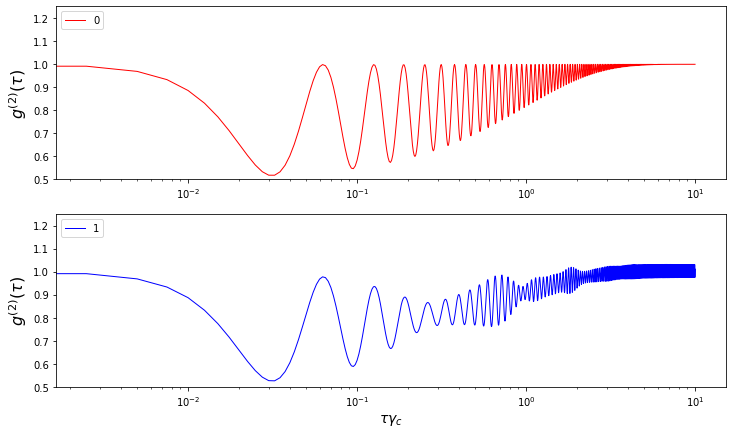

In [127]:
# for g_polr = 0 and 1

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,7))
#plt.semilogx(taus* gamma_c, np.real(g2), color='r' , lw=1.0)
ax1.plot(taus* gamma_c , np.real(g20), color='r' , lw=1.0)
ax2.plot(taus* gamma_c , np.real(g21), color='b' , lw=1.0)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylim([0.5, 1.25])
ax2.set_ylim([0.5, 1.25])
ax1.set_ylabel(r'$g^{(2)}(\tau)$',fontsize=16)
ax2.set_ylabel(r'$g^{(2)}(\tau)$',fontsize=16)
ax2.set_xlabel(r'$\tau \gamma_c$',fontsize=14)
ax1.legend("0",loc=2)
ax2.legend('1',loc=2)
#plt.ylim([0.5, 1.25])
#plt.xlim([0, 1.25])

# Fourier transform 

Expected to see figure like this

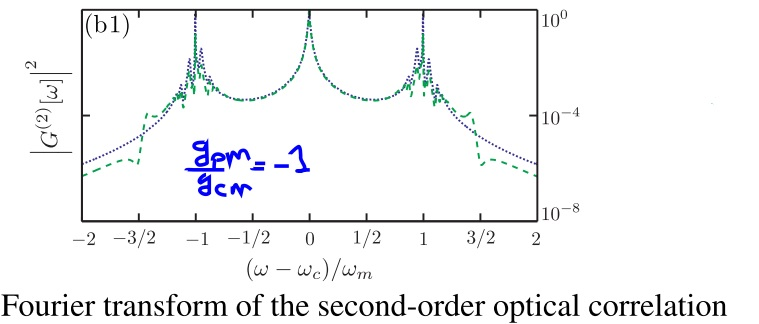

In [11]:
Image(filename='C:/Users/Ahmad/Desktop/2020/Python/g20_Autcr_ SS_03.07.2020/Fourier.jpg'\
      ,width=550, height=450)

(-2, 2)

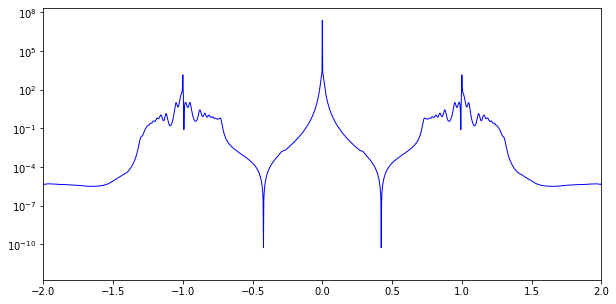

In [25]:
# for g_polr/g_cm = -1  equivalenty when g_am = g_cm
wlist1, spec1 = spectrum_correlation_fft(taus, g21)
fig, ax = plt.subplots(figsize=(10,5))


#plt.semilogy((wlist1), np.abs(spec1)**2, color='b' , lw=1.0)

ax.plot((wlist1), np.abs(spec1)**2, color='b' , lw=1.0)

ax.set_yscale('log')
ax.set_xlim([-2, 2])

In [ ]:
# for g_polr/g_cm = 1 
wlist1, spec1 = spectrum_correlation_fft(taus, g2)
fig, ax = plt.subplots(figsize=(14,6))
#ax.plot((wlist1 )/ (wm) , np.abs(spec1)**2, 'b', lw=2,)
plt.semilogy((wlist1), np.abs(spec1)**2, color='r' , lw=1.0)

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
plt.semilogx(taus* gamma_c, np.real(g2), color='r' , lw=1.0)
plt.ylim([0, 1.25])
# for g_polr = 0